In [93]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [94]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
hist.head()
target_col = 'close'

In [95]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [96]:
train, test = train_test_split(hist, test_size=0.2)

In [97]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18);

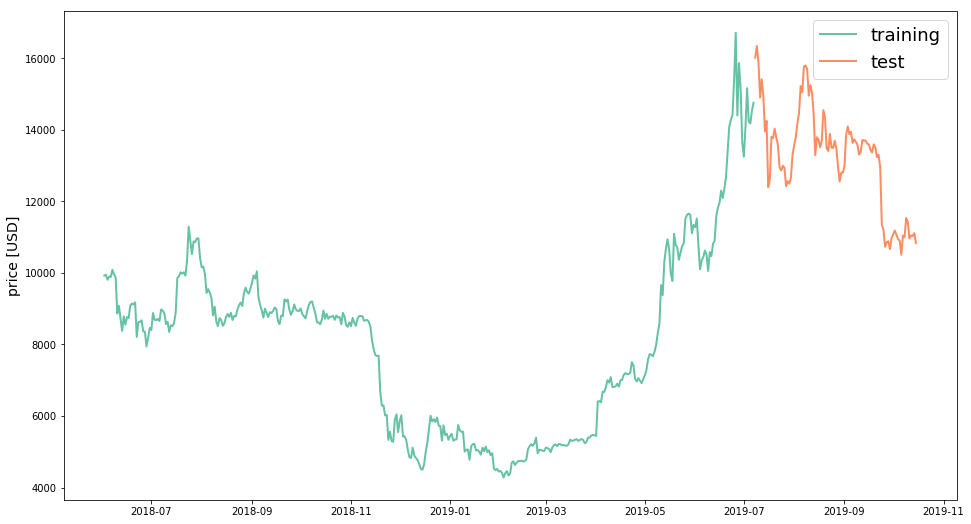

In [98]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [99]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [100]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [101]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [102]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [103]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [104]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [105]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
396/396 [==============================] - 1s 2ms/step - loss: 0.0082
Epoch 2/20
396/396 [==============================] - 0s 256us/step - loss: 0.0045
Epoch 3/20
396/396 [==============================] - 0s 255us/step - loss: 0.0041
Epoch 4/20
396/396 [==============================] - 0s 255us/step - loss: 0.0062
Epoch 5/20
396/396 [==============================] - 0s 261us/step - loss: 0.0046
Epoch 6/20
396/396 [==============================] - 0s 256us/step - loss: 0.0035
Epoch 7/20
396/396 [==============================] - 0s 264us/step - loss: 0.0035
Epoch 8/20
396/396 [==============================] - 0s 249us/step - loss: 0.0032
Epoch 9/20
396/396 [==============================] - 0s 272us/step - loss: 0.0040
Epoch 10/20
396/396 [==============================] - 0s 311us/step - loss: 0.0026
Epoch 11/20
396/396 [==============================] - 0s 261us/step - loss: 0.0026
Epoch 12/20
396/396 [==============================] - 0s 271us/step - loss: 0.0030
Epo

In [106]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.029131615757636533

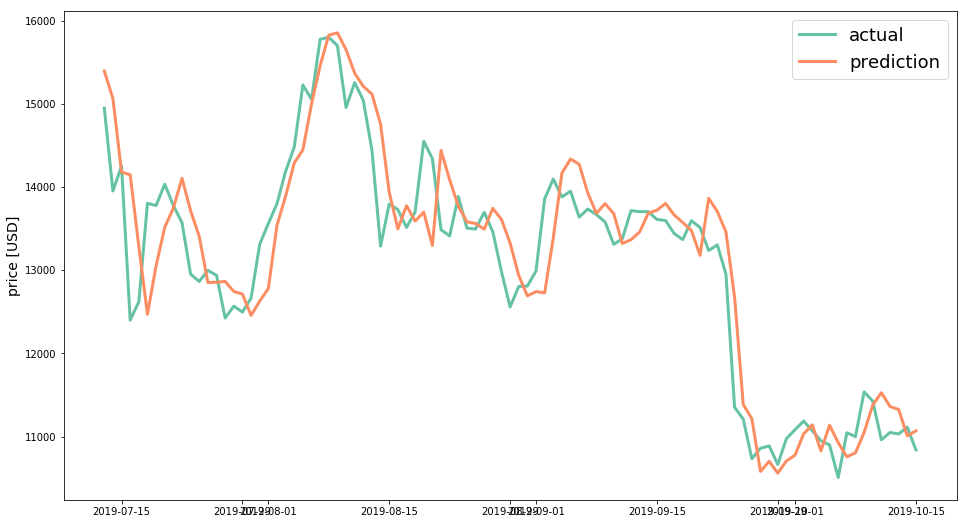

In [107]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [108]:
actual_returns = targets.pct_change()[1:]
predicted_returns = preds.pct_change()[1:]

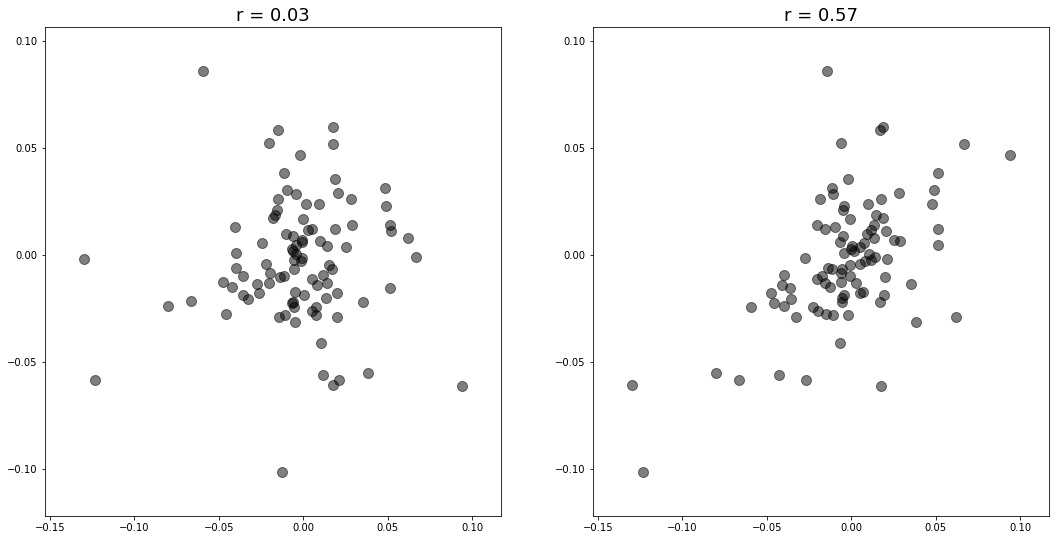

In [109]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
corr = np.corrcoef(actual_returns, predicted_returns)[0][1]
ax1.scatter(actual_returns, predicted_returns, color='k', marker='o', alpha=0.5, s=100)
ax1.set_title('r = {:.2f}'.format(corr), fontsize=18)
shifted_actual = actual_returns[:-1]
shifted_predicted = predicted_returns.shift(-1).dropna()
corr = np.corrcoef(shifted_actual, shifted_predicted)[0][1]
ax2.scatter(shifted_actual, shifted_predicted, color='k', marker='o', alpha=0.5, s=100)
ax2.set_title('r = {:.2f}'.format(corr), fontsize=18);